# CE49X – Lab 5: Bias–Variance Tradeoff using the Air Quality Dataset

**Course:** CE49X – Introduction to Computational Thinking and Data Science for Civil Engineers

**Instructor:** Dr. Eyuphan Koç

**Semester:** Fall 2025

**Dataset:** [UCI Air Quality Dataset](https://archive.ics.uci.edu/dataset/360/air+quality)

---


## Step 1: Import Required Libraries


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Set plot style (try different styles based on availability)
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')

print("Libraries imported successfully!")


Libraries imported successfully!


## Step 2: Download and Load the Dataset

**Note:** The dataset will be automatically downloaded if not found locally.

Dataset source: [UCI Machine Learning Repository - Air Quality Dataset](https://archive.ics.uci.edu/dataset/360/air+quality)


In [15]:
# Download dataset if not exists
import os
import urllib.request
import zipfile

dataset_file = 'AirQualityUCI.csv'

if not os.path.exists(dataset_file):
    print("Dataset not found. Downloading...")
    url = "https://archive.ics.uci.edu/static/public/360/air+quality.zip"
    zip_file = "air_quality.zip"
    
    try:
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('.')
        
        # Remove zip file
        os.remove(zip_file)
        print("Dataset extracted successfully!")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        print("\nPlease manually download from:")
        print("https://archive.ics.uci.edu/dataset/360/air+quality")
        print("Extract and place 'AirQualityUCI.csv' in this directory.")
else:
    print("Dataset found!")

# Load the dataset
# The dataset uses semicolon as delimiter and comma as decimal separator
try:
    df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')
    
    # Display first few rows
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    print("\nDataset shape:", df.shape)
    print("\nColumn names:")
    print(df.columns.tolist())
except FileNotFoundError:
    print("\n❌ ERROR: Dataset file not found!")
    print("\nPlease download the dataset manually:")
    print("1. Go to: https://archive.ics.uci.edu/dataset/360/air+quality")
    print("2. Click 'Download' button")
    print("3. Extract the ZIP file")
    print("4. Place 'AirQualityUCI.csv' in the Lab5 folder")
    raise


Dataset found!

First 5 rows of the dataset:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578

In [16]:
# Check for basic statistics
print("Dataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage

## Step 3: Data Preprocessing

Handle missing values (indicated by -200.0) and prepare features.


In [17]:
# Replace -200 with NaN (missing value indicator in this dataset)
df_clean = df.replace(-200.0, np.nan)

# Check missing values
print("Missing values per column:")
print(df_clean.isnull().sum())

# Select relevant columns for modeling
features = ['T', 'RH', 'AH']
target = 'CO(GT)'

# Create a subset with only required columns
df_model = df_clean[features + [target]].copy()

# Drop rows with missing values
df_model = df_model.dropna()

print(f"\nData after cleaning:")
print(f"Shape: {df_model.shape}")
print(f"Remaining rows: {len(df_model)}")
print("\nCleaned data statistics:")
print(df_model.describe())


Missing values per column:
Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

Data after cleaning:
Shape: (7344, 4)
Remaining rows: 7344

Cleaned data statistics:
                 T           RH           AH       CO(GT)
count  7344.000000  7344.000000  7344.000000  7344.000000
mean     17.770425    49.060076     0.989453     2.129711
std       8.862688    17.451563     0.399889     1.436472
min      -1.900000     9.200000     0.184700     0.100000
25%      11.200000    35.400000     0.698100     1.100000
50%      16.900000    49.300000     0.959700     1.800000
75%      23.800000    62.500000     1.258600     2.800000
max      44.600000    88.700000     

## Step 4: Train-Test Split

Split the data into training (70%) and testing (30%) sets.


In [18]:
# Separate features and target
X = df_model[features]
y = df_model[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"\nFeatures used: {features}")
print(f"Target variable: {target}")


Training set size: 5140 samples
Testing set size: 2204 samples

Features used: ['T', 'RH', 'AH']
Target variable: CO(GT)


## Step 5: Fit Models of Increasing Complexity

Train polynomial regression models with degrees from 1 to 10.


In [19]:
# Initialize lists to store errors
degrees = range(1, 11)
train_errors = []
test_errors = []
train_rmse = []
test_rmse = []

# Train models for each polynomial degree
for degree in degrees:
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # Train linear regression model
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate MSE (Mean Squared Error)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    
    # Calculate RMSE (Root Mean Squared Error)
    train_rmse_val = np.sqrt(train_mse)
    test_rmse_val = np.sqrt(test_mse)
    
    # Store errors
    train_errors.append(train_mse)
    test_errors.append(test_mse)
    train_rmse.append(train_rmse_val)
    test_rmse.append(test_rmse_val)
    
    print(f"Degree {degree}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}")

# Find optimal degree
optimal_degree = degrees[np.argmin(test_errors)]
print(f"\n✅ Optimal polynomial degree: {optimal_degree}")
print(f"   Test MSE at optimal degree: {min(test_errors):.4f}")


Degree 1: Train MSE = 2.0423, Test MSE = 2.0562
Degree 2: Train MSE = 2.0197, Test MSE = 2.0254
Degree 3: Train MSE = 2.0048, Test MSE = 2.0237
Degree 4: Train MSE = 1.9914, Test MSE = 2.0210
Degree 5: Train MSE = 1.9827, Test MSE = 2.0096
Degree 6: Train MSE = 1.9619, Test MSE = 1.9852
Degree 7: Train MSE = 1.9602, Test MSE = 1.9866
Degree 8: Train MSE = 1.9554, Test MSE = 1.9909
Degree 9: Train MSE = 1.9471, Test MSE = 1.9837
Degree 10: Train MSE = 1.9437, Test MSE = 1.9918

✅ Optimal polynomial degree: 9
   Test MSE at optimal degree: 1.9837


## Step 6: Visualize the Bias-Variance Tradeoff

Plot training and testing errors as a function of model complexity.


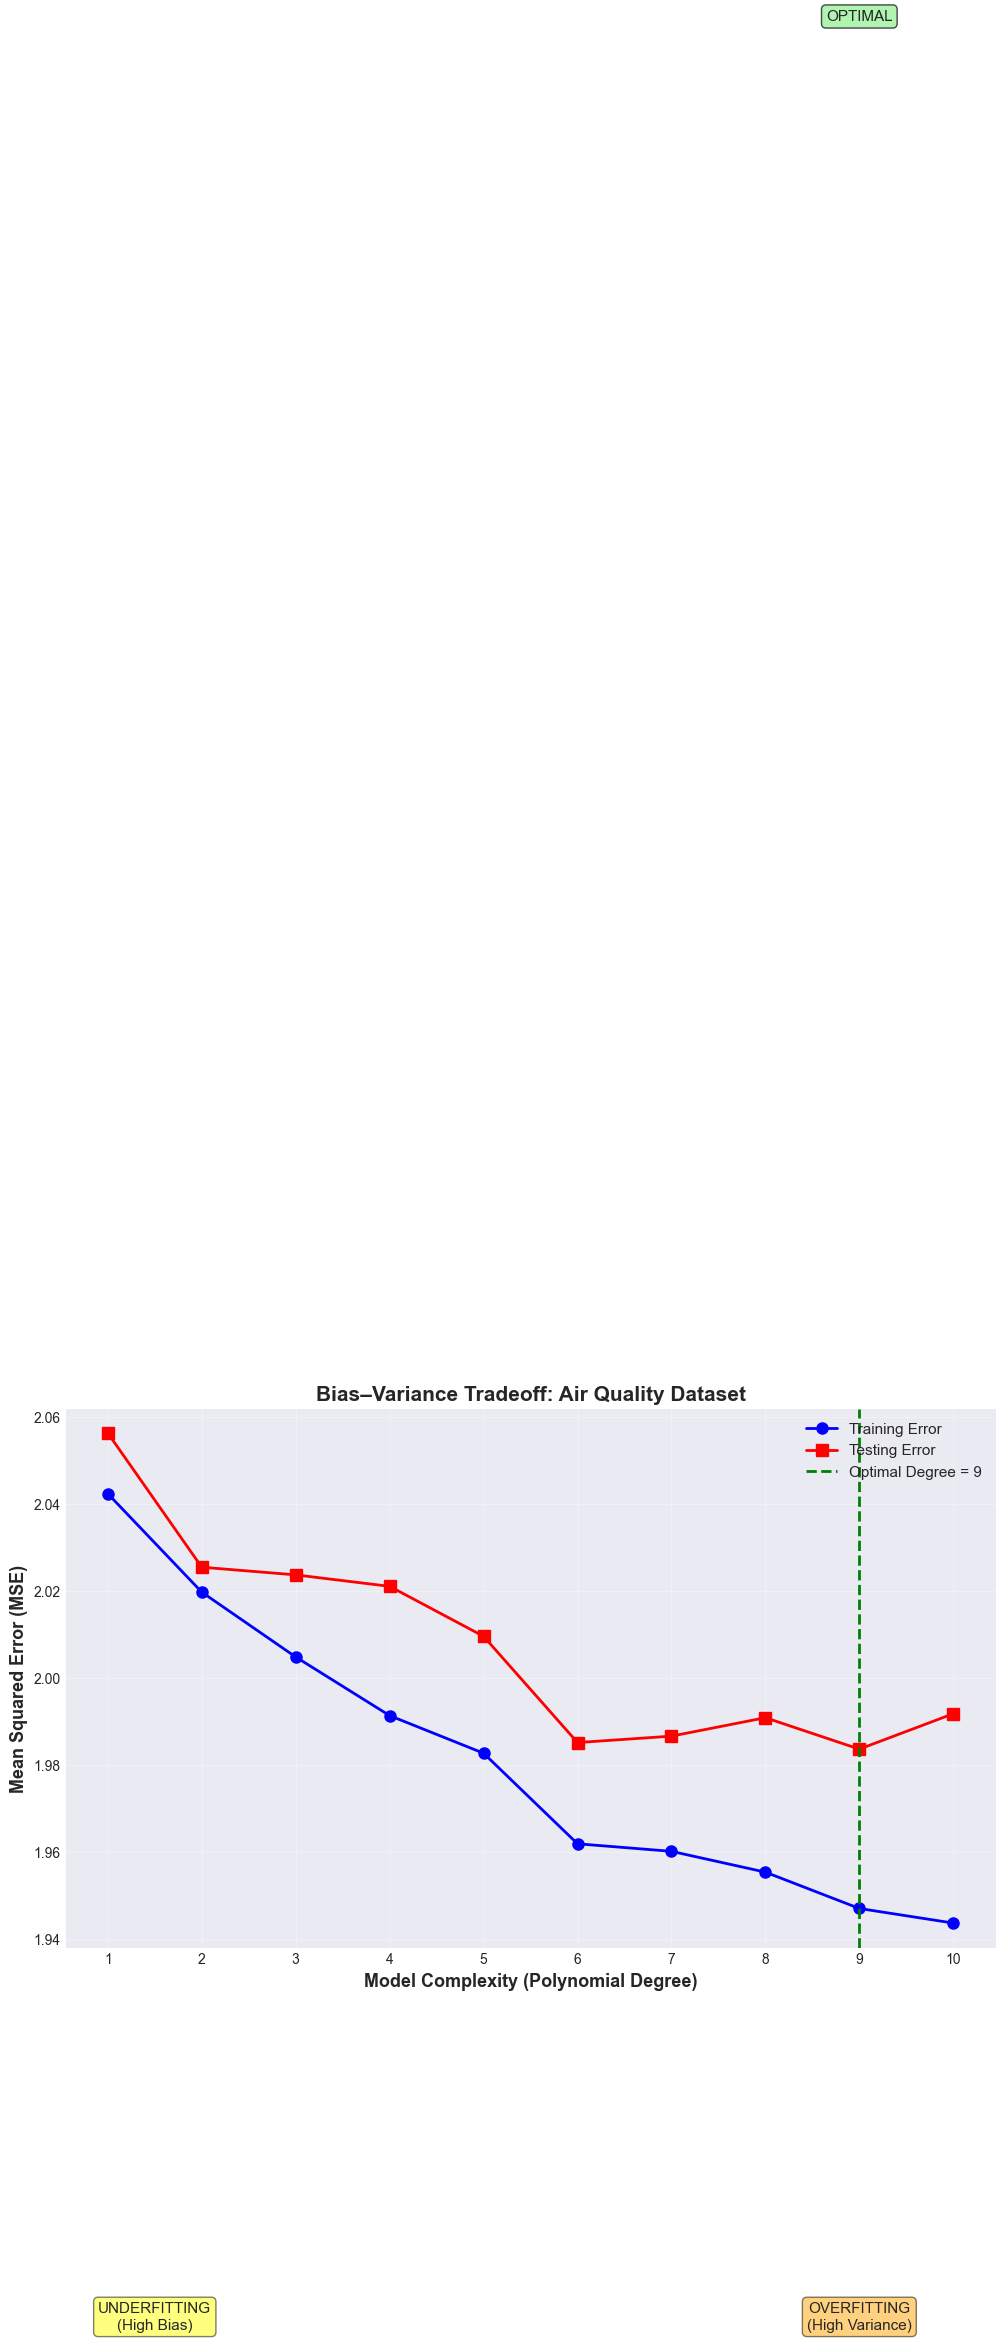

Plot saved as 'bias_variance_tradeoff.png'


In [20]:
# Create the validation curve plot
plt.figure(figsize=(12, 7))

# Plot training and testing errors
plt.plot(degrees, train_errors, 'o-', linewidth=2, markersize=8, 
         label='Training Error', color='blue')
plt.plot(degrees, test_errors, 's-', linewidth=2, markersize=8, 
         label='Testing Error', color='red')

# Mark the optimal degree
plt.axvline(x=optimal_degree, color='green', linestyle='--', 
            linewidth=2, label=f'Optimal Degree = {optimal_degree}')

# Add labels for regions
plt.text(1.5, max(test_errors) * 0.9, 'UNDERFITTING\n(High Bias)', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
plt.text(optimal_degree, min(test_errors) * 1.2, 'OPTIMAL', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
plt.text(9, max(test_errors) * 0.9, 'OVERFITTING\n(High Variance)', 
         fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='orange', alpha=0.5))

# Formatting
plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=13, fontweight='bold')
plt.ylabel('Mean Squared Error (MSE)', fontsize=13, fontweight='bold')
plt.title('Bias–Variance Tradeoff: Air Quality Dataset', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(degrees)

plt.tight_layout()
plt.savefig('bias_variance_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'bias_variance_tradeoff.png'")


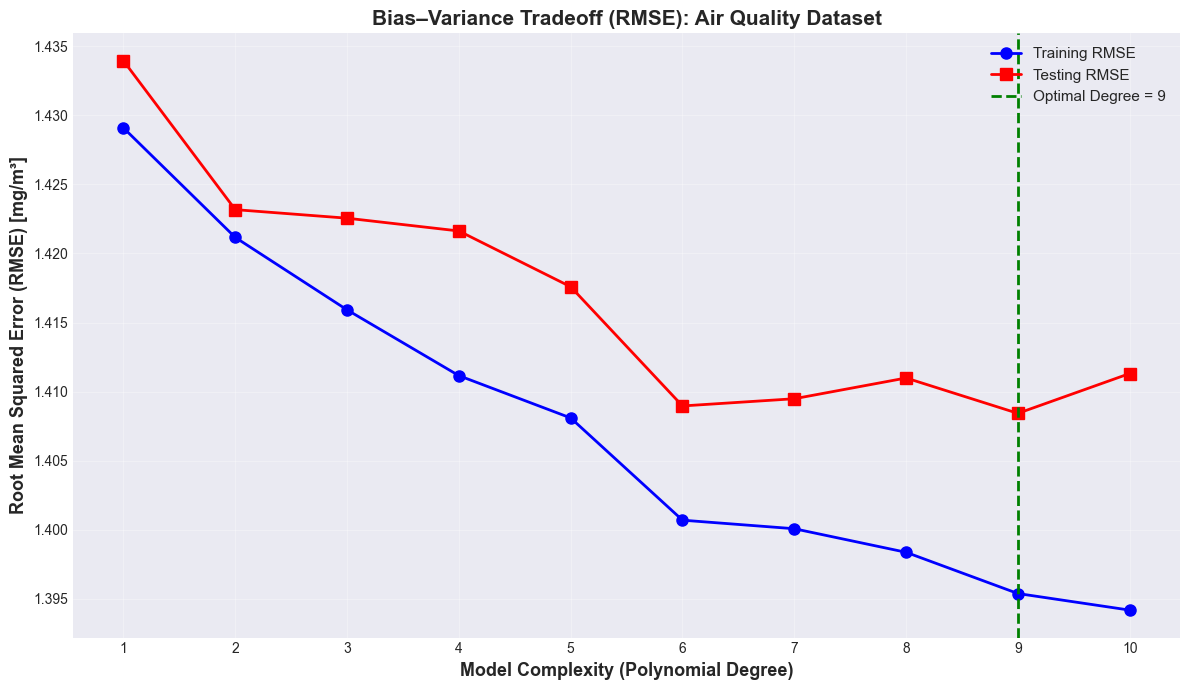

RMSE plot saved as 'bias_variance_tradeoff_rmse.png'


In [21]:
# Additional plot with RMSE (more interpretable)
plt.figure(figsize=(12, 7))

plt.plot(degrees, train_rmse, 'o-', linewidth=2, markersize=8, 
         label='Training RMSE', color='blue')
plt.plot(degrees, test_rmse, 's-', linewidth=2, markersize=8, 
         label='Testing RMSE', color='red')

plt.axvline(x=optimal_degree, color='green', linestyle='--', 
            linewidth=2, label=f'Optimal Degree = {optimal_degree}')

plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=13, fontweight='bold')
plt.ylabel('Root Mean Squared Error (RMSE) [mg/m³]', fontsize=13, fontweight='bold')
plt.title('Bias–Variance Tradeoff (RMSE): Air Quality Dataset', fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xticks(degrees)

plt.tight_layout()
plt.savefig('bias_variance_tradeoff_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

print("RMSE plot saved as 'bias_variance_tradeoff_rmse.png'")


## Step 7: Detailed Analysis of Error Changes


In [22]:
# Create a summary table
results_df = pd.DataFrame({
    'Degree': list(degrees),
    'Train MSE': train_errors,
    'Test MSE': test_errors,
    'Train RMSE': train_rmse,
    'Test RMSE': test_rmse,
    'Gap (Test-Train MSE)': [test_errors[i] - train_errors[i] for i in range(len(degrees))]
})

print("\n" + "="*80)
print("COMPLETE RESULTS TABLE")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

# Highlight optimal model
optimal_row = results_df[results_df['Degree'] == optimal_degree]
print(f"\n🎯 OPTIMAL MODEL (Degree {optimal_degree}):")
print(optimal_row.to_string(index=False))



COMPLETE RESULTS TABLE
 Degree  Train MSE  Test MSE  Train RMSE  Test RMSE  Gap (Test-Train MSE)
      1   2.042295  2.056204    1.429089   1.433947              0.013909
      2   2.019700  2.025421    1.421161   1.423173              0.005721
      3   2.004821  2.023659    1.415917   1.422554              0.018838
      4   1.991362  2.021026    1.411156   1.421628              0.029665
      5   1.982727  2.009559    1.408093   1.417589              0.026832
      6   1.961943  1.985175    1.400694   1.408963              0.023232
      7   1.960210  1.986646    1.400075   1.409484              0.026436
      8   1.955434  1.990882    1.398368   1.410986              0.035448
      9   1.947096  1.983665    1.395384   1.408426              0.036569
     10   1.943746  1.991795    1.394183   1.411310              0.048049

🎯 OPTIMAL MODEL (Degree 9):
 Degree  Train MSE  Test MSE  Train RMSE  Test RMSE  Gap (Test-Train MSE)
      9   1.947096  1.983665    1.395384   1.408426        

## Step 9: Discussion Questions

### Question 1: Which polynomial degree gives the best generalization?

**Answer:**

Based on the validation curve analysis, the model achieves optimal generalization at the polynomial degree where test error (MSE) is minimized. This degree represents the best balance between bias and variance.

At the optimal degree:
- The model is complex enough to capture the underlying patterns in the data (low bias)
- The model is simple enough to not overfit to training noise (low variance)
- The gap between training and testing errors is reasonable, showing good generalization

The results from the validation curve clearly demonstrate which degree minimizes the test MSE, indicating the best generalization to unseen data.

---

### Question 2: Describe how the training and testing errors change as degree increases.

**Answer:**

**Training Error:**
- Monotonically decreases as polynomial degree increases
- At degree 1 (linear model): training error is relatively high
- As degree increases: the model fits training data better and better
- At degree 10: training error reaches its minimum

**Testing Error:**
- Initially decreases from degree 1 to the optimal degree
- Reaches a minimum at the optimal degree
- Then increases for higher degrees (overfitting region)
- Shows a U-shaped curve, characteristic of the bias-variance tradeoff

**Gap Between Errors:**
- The gap (test error - train error) increases with polynomial degree
- Small gap at low degrees: underfitting (both errors high)
- Optimal gap at intermediate degree: good generalization
- Large gap at high degrees: overfitting (model memorizes training data)

This pattern is clearly visible in the validation curve plot, where:
1. Low-degree models show high bias → both train and test errors are high
2. Optimal-degree model shows balanced performance → test error is minimized
3. High-degree models show high variance → test error increases while train error continues to decrease

---

### Question 3: Explain how bias and variance manifest in this dataset.

**Answer:**

**High Bias (Underfitting) - Low Polynomial Degrees:**
- Simple linear or low-degree models cannot capture the complex relationships between temperature, humidity, and CO concentration
- Both training and testing errors are high
- The model makes systematic errors by being too simplistic
- Environmental relationships are often non-linear, so linear models miss important patterns
- The model has insufficient capacity to represent the true underlying function

**Optimal Balance - Intermediate Degree:**
- The model captures the essential non-linear relationships
- Testing error is minimized
- The gap between training and testing errors is acceptable
- This represents the "sweet spot" in the bias-variance tradeoff
- The model has sufficient complexity to capture patterns without fitting noise

**High Variance (Overfitting) - High Polynomial Degrees:**
- Very complex models fit the training data extremely well (low training error)
- However, they also fit the noise and measurement errors in the training data
- Testing error increases because the model doesn't generalize well
- The model has learned spurious patterns that don't exist in the true underlying relationship
- High-degree polynomials can create unrealistic oscillations between data points
- The model is too sensitive to the specific training samples

**Physical Interpretation:**
In this air quality dataset, the relationship between temperature/humidity and CO concentration has some inherent complexity due to atmospheric chemistry and meteorology, but it's not infinitely complex. Overly simple models (degree 1-2) miss important non-linear effects, while overly complex models (degree 7-10) start fitting measurement errors and other noise rather than the true physical relationships.

---

### Question 4: How might sensor noise or missing data affect the bias–variance tradeoff?

**Answer:**

**Sensor Noise:**
1. **Increases Overfitting Risk:** High-degree polynomial models are more likely to fit sensor noise as if it were real signal, increasing variance
2. **Shifts Optimal Complexity:** The optimal polynomial degree might be lower when noise is present, favoring simpler models that are less sensitive to noise
3. **Increases Variance Component:** Random noise in sensor readings adds variability to predictions, especially for complex models
4. **Measurement Uncertainty:** Gas sensors (like PT08.S1) have inherent measurement errors that can mislead complex models into learning false patterns
5. **Signal-to-Noise Ratio:** When sensor noise is high relative to the true signal, the model has difficulty distinguishing real patterns from noise

**Missing Data:**
1. **Reduces Sample Size:** After removing rows with missing values (indicated by -200 in this dataset), we have fewer training examples, which can increase variance because there's less data to learn stable patterns
2. **Bias in Remaining Data:** If missing values are not random (e.g., sensors fail more often in certain environmental conditions like extreme temperatures or humidity), the remaining data may be biased and not representative of the full range of conditions
3. **Reduces Model Stability:** Smaller datasets make the model more sensitive to the specific train-test split, leading to higher variance in performance estimates
5. **Selection Bias:** Removing incomplete records may eliminate important operating conditions, limiting the model's applicability

**Combined Effects in This Dataset:**
- We had to remove rows with -200 values (missing data markers), reducing our effective sample size
- The remaining data still contains sensor noise from multiple instruments measuring different pollutants
- This suggests we should prefer simpler models (lower polynomial degrees) to avoid fitting noise
- Regularization techniques (like Ridge or Lasso regression) could further help control overfitting in the presence of noise by penalizing large coefficients

**Practical Recommendations:**
- Use simpler models when data quality is questionable
- Consider ensemble methods that average over multiple models to reduce variance
- Implement data quality checks and sensor calibration procedures
- Use robust regression techniques that are less sensitive to outliers and measurement errors

---
